# Import

In [6]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import contractions
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("english"))

import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader, random_split 
from torch import nn
import torch 

from tqdm import tqdm
import math

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jamesnguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading dataset

In [7]:
root = os.getcwd()
#yelp polarity has 2 labels, 
#yelp dataset has 5 labels, they have the same text content
train_datapath = os.path.join(root, 'dataset', 'yelp_polarity', 'train.csv') 
test_datapath = os.path.join(root,  'dataset', 'yelp_polarity', 'test.csv') 

assert os.path.exists(train_datapath),  f"train dataset path {train_datapath} not found"
assert os.path.exists(test_datapath),   f"test dataset path {test_datapath} not found"

sample_size = 0.1

In [8]:
train_df = pd.read_csv(train_datapath, names = ["review","text"])
train_df = train_df.sample(frac = sample_size)
print(train_df.shape)
train_df.reset_index(inplace=True, drop = True)
train_df.head()

(56000, 2)


,review,text
0,2,This place is awesome!!! Super convenient when...
1,1,The YMCA in Madison is a very old building and...
2,1,Worst experience ever. They damaged the table ...
3,2,Just back for 2 nights away & loved our experi...
4,2,I went this place not too long after they open...


# Cleaning

In [9]:
# Cleaning Text

def remove_urls(text):
    #if there's link in text, like www.something.com, https://www.something.com,
    # replace it with the <url> token
    pattern = re.compile(r'https?://\S+|www\.\S+')
    text = pattern.sub(' ', text)
    return text

def remove_digits(text):
    return re.sub("\d", ' ', text)

def remove_punctation(text):
    return re.sub(r'[^\w\s]',' ',text)

def expand_contraction(text):
    return contractions.fix(text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split(' ') if word not in STOPWORDS])

def clean_text(text):
    '''
    extract feature and label from line and process the text
    @params:
        text: string, format: __label__2 some text.
    @return:
        feature: string
        label: int, 0: bad review, 1 good review
    '''
    #Each line has format: __label__2 some text.
    #The first part is label, the rest is text feature
    #lower case the features
    text = text.lower()
    #start cleaning

    #remove urls in text
    text = remove_urls(text)
    #remove digits
    text = remove_digits(text)
    # # #expand contractions
    text = expand_contraction(text)
    # # #remove punctuations
    text = remove_punctation(text)
    # # #remove stop words
    text = remove_stopwords(text)

    #after cleaning, there's a letter n that occur most frequently
    #this don't make sense so remove a standalone letter n
    text = ' '.join(t for t in text.split() if t != '' and t != 'n')
    return text.strip()

test_string = '''This is a test string. Here are some special characters: &,#,$. How about some punctuations? !@#$%^&*()_+=-`~{[]}|:;'<,>.?/"|https://www.example.com'''

clean_text(test_string)


'test string special characters punctuations _'

In [10]:
eda_df = train_df.copy()
eda_df['text'] = eda_df['text'].apply(lambda s: clean_text(s))
eda_df.head()

,review,text
0,2,place awesome super convenient need work break...
1,1,ymca madison old building infrastructure many ...
2,1,worst experience ever damaged table purchased ...
3,2,back nights away loved experience except lame ...
4,2,went place long opened border line pretentious...


# A little EDA

In [11]:
# wordcloud of common words
freq = collections.Counter()

for row in eda_df.iterrows():
    label, text = row[1]
    freq.update(text.split())

print('most frequent words')
print(freq.most_common(10))


most frequent words
[('place', 32660), ('food', 32644), ('good', 29721), ('would', 27964), ('like', 26339), ('one', 23777), ('get', 23544), ('time', 21670), ('great', 20952), ('service', 20744)]


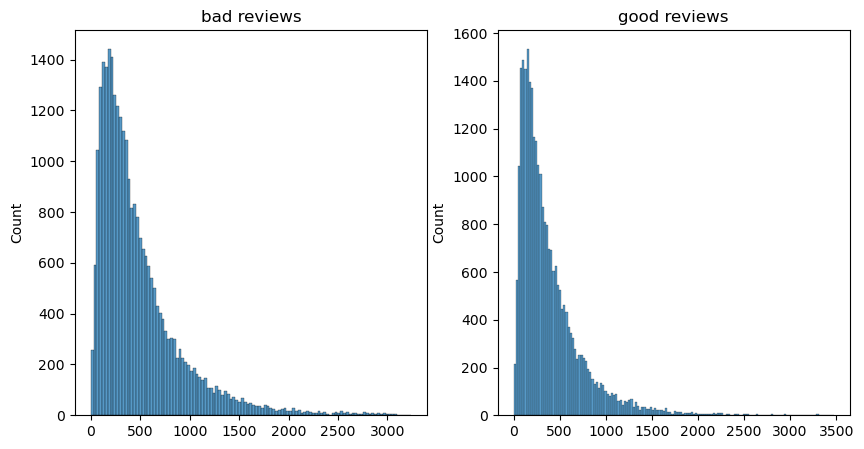

In [12]:
bad_reviews = eda_df.loc[eda_df['review'] == 1]['text'].apply(lambda s: len(s)).values
good_reviews = eda_df.loc[eda_df['review'] == 2]['text'].apply(lambda s: len(s)).values
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))
sns.histplot(x = bad_reviews, label = 'bad reviews', ax = ax1)
ax1.set_title('bad reviews')
sns.histplot(x = good_reviews, label = 'good reviews', ax = ax2)
ax2.set_title('good reviews')
plt.show()

review
1    28137
2    27863
Name: count, dtype: int64


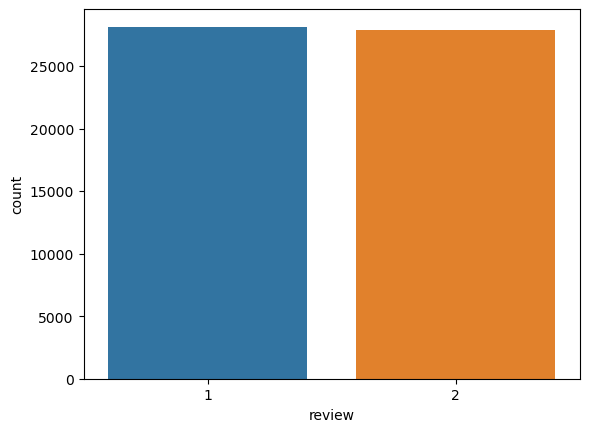

In [13]:
print(eda_df['review'].value_counts())
sns.countplot(x = eda_df['review'])
plt.show()

# Prepare data

In [14]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

def build_array(X, maxlength = 256):
    X_tokens = []
    X_lengths = []
    for text in tqdm(X):
        tokens = tokenizer(text)[:maxlength]
        X_tokens.append(tokens)
        X_lengths.append(len(tokens))

    return X_tokens, X_lengths


def get_ids(tokens, vocab):
    ids = vocab.lookup_indices(tokens)
    return torch.tensor(ids)

def build_train_test_data(feature_train, label_train, min_vocab_freq = 5, **kwargs):
    train_tokens, train_lengths = build_array(feature_train)

    unk_token = '<unk>'
    pad_token = '<pad>'
    special_tokens = [unk_token, pad_token]

    vocab = torchtext.vocab.build_vocab_from_iterator(
        train_tokens,
        min_freq=min_vocab_freq,
        specials=special_tokens,
    )

    unk_id = vocab[unk_token]
    pad_id = vocab[unk_token]

    vocab.set_default_index(unk_id)

    print('vocab len = ', len(vocab))

    def convert_to_ids_labels_lengths(token_list, labels, lengths):
        id_list = []

        for tokens in tqdm(token_list):
            ids = get_ids(tokens, vocab)
            id_list.append(ids)

        #convert y to tensor
        labels = torch.tensor([0 if label == 1 else 1 for label in labels])
        #convert X lengths to tensor
        lengths = torch.tensor(lengths)

        return id_list, labels, lengths

    train_ids, train_y, train_lengths = convert_to_ids_labels_lengths(train_tokens, label_train, train_lengths)

    return (train_tokens, train_ids, train_y, train_lengths), vocab, pad_id

In [15]:
X_array = train_df['text'].apply(lambda s: clean_text(s)).values
y_array = train_df['review'].values

(train_tokens, train_ids, train_y, train_lengths), vocab, pad_id = build_train_test_data(X_array, y_array)

train_ids = pad_sequence(train_ids, batch_first=True, padding_value=pad_id)

print('ids shape = ', train_ids.shape )
print('y shape = ', train_y.shape )
print('lengths shape = ', train_lengths.shape)

100%|██████████| 56000/56000 [00:00<00:00, 56980.98it/s]


vocab len =  22231


100%|██████████| 56000/56000 [00:00<00:00, 62156.07it/s]


ids shape =  torch.Size([56000, 256])
y shape =  torch.Size([56000])
lengths shape =  torch.Size([56000])


In [16]:
for label, token, id, length in zip(train_y[:1], train_tokens[:1], train_ids[:1], train_lengths[:1]):
    print(f'label={label}\ntokens={token}\nlength={length}\nids={id}')

print('vocab len = ', len(vocab))

label=1
tokens=['place', 'awesome', 'super', 'convenient', 'need', 'work', 'break', 'owner', 'really', 'helpful', 'different', 'flavor', 'choices', 'self', 'serve', 'frozen', 'yogurt', 'toppings', 'get', 'better']
length=20
ids=tensor([   2,  166,  204, 1192,  128,  113, 1014,  322,   14,  417,  136,  182,
         680, 1217,  479,  658, 1367,  862,    8,   38,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,   

In [17]:
class AmazonReviewDataset(Dataset):

    def __init__(self, ids, labels, lengths):
        self.ids = ids
        self.labels = labels
        self.lengths = lengths

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return self.ids[idx], self.labels[idx], self.lengths[idx]

NUM_CLASSES = len(set(list(train_y.tolist())))

train_dataset = AmazonReviewDataset(train_ids[:100], train_y[:100], train_lengths[:100])

train_ratio = 0.8
train_len = int(train_ratio * len(train_dataset))
val_len = len(train_dataset) - train_len
train_dataset, val_dataset = random_split(train_dataset,[train_len, val_len])


BATCH_SIZE = 256
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle = True)

print('num class = ', NUM_CLASSES)
print('train dataset len = ', len(train_dataset))
print('train dataloader len = ', len(train_dataloader))
print('val dataset len = ', len(val_dataset))
print('val dataloader len = ', len(val_dataloader))

num class =  2
train dataset len =  80
train dataloader len =  1
val dataset len =  20
val dataloader len =  1


# Test Model

In [18]:
class PositionalEncoding(nn.Module):

    def __init__(self, num_hiddens: int, dropout:float = 0, max_len: int = 5000):
        super().__init__()
        assert num_hiddens % 2 == 0, f'num hiddens ({num_hiddens}),has to be even'

        self.dropout = nn.Dropout(dropout)

        self.P = torch.zeros((1, max_len, num_hiddens))
        x = torch.arange(max_len).float().unsqueeze(1)
        #N = 10000 as defined in the Attention is All You Need paper
        denom = torch.pow(10000, torch.arange(0, num_hiddens,2).float()/num_hiddens)
        x = x/denom
        self.P[:,:,0::2] = torch.sin(x)
        self.P[:,:,1::2] = torch.cos(x)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, length, num_hiddens = x.shape
        x = x + self.P[:,:length,:].to(x.device)
        return self.dropout(x)

In [27]:
class TransformerClassifier(nn.Module):
    def __init__(self, input_size, num_class, 
    num_heads, dim_fc, num_tokens,
    dropout = 0.2, num_encoder_layers = 2, batch_first = True):

        '''
        @params:
            input_size: input features or embedding size
            num_heads: number of multi attentino heads 
            dim_fc:  dimension of feedforward layer
            dropout: drop out rate
            num_tokens: number of tokens in vocabulary (some call vocab_size)
        '''
        super().__init__()

        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(input_size, dropout)
        encoder_layers = nn.TransformerEncoderLayer(
            d_model = input_size,
            nhead = num_heads,
            dim_feedforward= dim_fc,
            dropout = dropout,
            batch_first=batch_first
        )

        self.encoder = nn.TransformerEncoder(encoder_layer=encoder_layers, num_layers = num_encoder_layers)
        self.embedding = nn.Embedding(num_tokens, input_size)
        self.input_size = input_size 

        self.fc = nn.Linear(input_size, num_class) 

        self._init_weights()
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)
    
    def _init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)
    
    def forward(self, src, mask = None):
        batch_size, input_len = src.shape
        
        src = self.embedding(src)
        src = src * math.sqrt(self.input_size)
        src = self.pos_encoder(src)

        if mask == None:
            mask = nn.Transformer.generate_square_subsequent_mask(input_len)

        transformer_output = self.encoder(src, mask)
        output = self.fc(transformer_output) 
        return output

input_size = 100 
num_class = 2
num_heads = 5
fc_hidden_size = 5
num_tokens = 1000

# clf = TransformerClassifier(input_size, num_class, num_heads, fc_hidden_size, num_tokens)
# X = torch.randint(0,1000,(10,5))
# y = clf(X, None)

In [22]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

def train(dataloader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for ids, label, length in tqdm(dataloader, desc="training..."):
        ids = ids.to(device)
        length = length
        label = label.to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def evaluate(dataloader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    for ids, label, length in tqdm(dataloader, desc="evaluating..."):
        ids = ids.to(device)
        length = length
        label = label.to(device)
        prediction = model(ids, length)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

def tune(model, optimizer, criterion, epochs = 10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"The model has {model.count_parameters()} trainable parameters")

    model = model.to(device)
    criterion = criterion.to(device)
    best_valid_loss = float("inf")
    history = []

    history = collections.defaultdict(list)

    for epoch in range(epochs):
        train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
        val_loss, val_acc = evaluate(val_dataloader, model, criterion, device)
        # test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)
        history["train_losses"].append(train_loss)
        history["train_accs"].append(train_acc)
        history["valid_losses"].append(val_loss)
        history["valid_accs"].append(val_acc)
        # history["test_losses"].append(test_loss)
        # history["test_accs"].append(test_acc)
        # if test_loss < best_valid_loss:
        #     best_valid_loss = test_loss
        #     torch.save(model, f"lstm.checkpoint.pt")
        print(f"epoch: {epoch}")
        print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
        print(f"val_loss: {val_loss:.3f}, valid_acc: {val_acc:.3f}")
        # print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

    return history

def plot(history):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    epochs = list(range(len(history['train_accs'])))
    sns.lineplot(y = history["train_accs"],   label ='train accuracy',  x = epochs, ax = ax1)
    sns.lineplot(y = history["valid_accs"],   label ='val accuracy',    x = epochs, ax = ax1)
    # sns.lineplot(y = history["test_accs"],  label ='test accuracy', x = epochs, ax = ax1)
    ax1.set_title("Accuracy")

    sns.lineplot(y = history["train_losses"], label ='train loss', x = epochs, ax = ax2)
    sns.lineplot(y = history["valid_losses"],   label ='val loss', x = epochs, ax = ax2)
    # sns.lineplot(y = history["test_losses"],  label ='test loss', x = epochs, ax = ax2)
    ax2.set_title("Loss")

# Pretrained embedding

In [20]:
vectors = torchtext.vocab.GloVe()
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

# Test run LSTM

In [28]:
lr = 5e-4
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 300
output_dim = NUM_CLASSES
print('output dim = ', output_dim)
n_layers = 2
bidirectional = True
dropout_rate = 0.5

model = TransformerClassifier(
    input_size = embedding_dim,
    num_class=NUM_CLASSES,
    num_heads = 2,
    dim_fc = 128,
    num_tokens = vocab_size
)

model.embedding.weight.data = pretrained_embedding

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

history = tune(model, optimizer, criterion, epochs = 2)

plot(history)

output dim =  2
The model has 7549158 trainable parameters


training...:   0%|          | 0/1 [00:00<?, ?it/s]


AssertionError: only bool and floating types of mask are supported